# 各種インポート

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q timm
!pip install -q torchmetrics

     |████████████████████████████████| 509 kB 8.3 MB/s 
     |████████████████████████████████| 419 kB 7.9 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms as T
import timm
from torchmetrics import F1Score
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# データの読み込み

In [ ]:
images = np.load('/content/drive/MyDrive/Competition/ProbSpace/日本画/data/train_data.npz')
print(images.files)

['arr_0', 'arr_1']


In [ ]:
print(images['arr_0'].shape)
print(images['arr_1'].shape)

(6446, 256, 256, 3)
(6446,)


In [ ]:
train_images = images['arr_0']
train_labels = images['arr_1']

In [ ]:
train_images = train_images.transpose((0,3,1,2))

In [ ]:
# 貴族、武士、化け物、平民
classes = {0: 'noble', 1: 'warrior', 2: 'incarnetion', 3: 'commoner'}

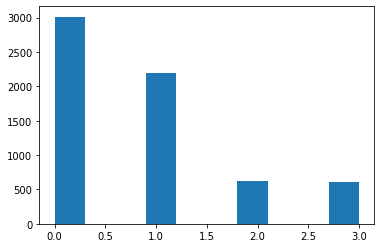

In [ ]:
plt.figure()
plt.hist(train_labels)
plt.show()

In [ ]:
# test data
#test_images = np.load('/content/drive/MyDrive/Competition/ProbSpace/日本画/data/test_data.npz')['arr_0']
#test_images = test_images.transpose((0,3,1,2))
#test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_images).float())
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, pin_memory=True)

In [ ]:
class My_Dataset(Dataset):

  def __init__(self, images, labels, transform=None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.transform = transform

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

  def __len__(self):
    return len(self.labels)


def train_transformer(n=1, m=1):
  return T.Compose([T.RandAugment(num_ops=n, magnitude=m)])

def valid_transformer():
  return T.Compose([T.ToTensor()])

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

In [ ]:
for fold, (train_index, valid_index) in enumerate(kf.split(train_images, train_labels)):
    if fold == 2:
      pass
    else:
      continue

    valid_dataset = My_Dataset(torch.from_numpy(train_images[valid_index]).float(), torch.from_numpy(train_labels[valid_index].astype(np.int64)))
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
valid_dataset.labels

tensor([1, 0, 2,  ..., 1, 1, 1])

In [ ]:
len(valid_dataset.labels)

1289

# モデルの読み込み

In [ ]:
#model_name = 'resnet34'
model_name = 'tf_efficientnet_b3_ns'
num_classes = 4
# 学習済みモデル
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/fold*')
weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/TF_EfficientNetB3_NS/fold2*0729.pth')
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/eff_b3_FocalLoss_weight_fold0*')
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/eff_b3_FocalLoss_fold1')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
all_predicts = np.zeros((len(valid_dataset.labels), 4))
with torch.no_grad():
  for w in weights:
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(w))
    mode = model.to(device)
    model.eval()
    predicts = []
    for batch in valid_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      #x = x[0].to(device)
      #outputs = model(x)
      #preds = torch.max(outputs, dim=1)[1]
      predicts.append(outputs.cpu().numpy())
    all_predicts += np.concatenate(predicts)

In [ ]:
all_predicts

array([[-0.36933857,  3.17106986, -0.88981235,  0.62419873],
       [ 3.43182921, -0.06996605, -0.7701757 ,  0.77968401],
       [-0.63130456, -0.86741364,  2.69307733,  0.48670813],
       ...,
       [-0.22483055,  3.57809567, -0.73478824,  0.81929886],
       [-0.21056984,  3.21834016, -1.03495181,  0.65681344],
       [-1.00320268,  2.74975228, -1.52311623,  2.31968951]])

In [ ]:
print(all_predicts.shape)
results = np.argmax(all_predicts, axis=1)
results.shape

(1289, 4)


(1289,)

In [ ]:
results

array([1, 0, 2, ..., 1, 1, 1])

# 推論結果

              precision    recall  f1-score   support

           0      0.927     0.949     0.938       603
           1      0.918     0.870     0.894       440
           2      0.930     0.960     0.944       124
           3      0.677     0.705     0.691       122

    accuracy                          0.900      1289
   macro avg      0.863     0.871     0.867      1289
weighted avg      0.901     0.900     0.900      1289



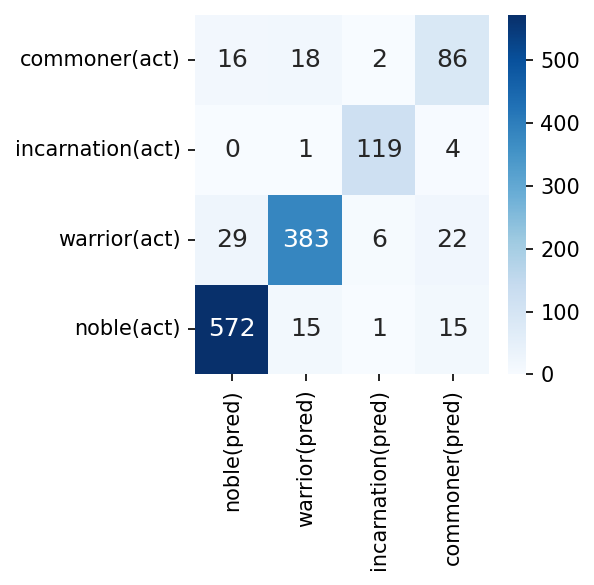

In [ ]:
#混同行列の作成
labels = [0, 1, 2, 3]
re_labels = ["noble", "warrior", "incarnation", "commoner"]
conf_mx = confusion_matrix(valid_dataset.labels, results, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(valid_dataset.labels, results, labels=labels, digits=3))

In [ ]:
sub = pd.DataFrame(results, columns=['y'])
sub.index.name = 'id'
sub.index += 1

In [ ]:
sub.to_csv('/content/drive/MyDrive/Competition/ProbSpace/日本画/submission/submission09.csv')